# Singapore Weather Prediction

In [1]:
# setup
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyo
import requests

from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from time import time

pyo.init_notebook_mode(connected=True)
# pio.renderers.default = "notebook" # must trust notebook for it to work

### Data Acquisition

Data source: [data.gov.sg](https://data.gov.sg/) - National Environment Agency

Data format: CKAN APIs 
- access to static tabular data such as time series or listings
- alternative to the data.gov.sg web interface
- provides both RESTful and functional interfaces, all in JSON format, making it suitable for a wide range of clients.

API used: CKAN Datastore Search
- GET URL with endpoint: https://data.gov.sg/api/action/datastore_search

| Name               | Description                                                                                                                                                                                                                                                                                                                                                      |
|:-------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **resource_id \*** | ID or alias of the resource to be searched against                                                                                                                                                                                                                                                                                                               |
| limit              | Maximum number of rows to return (optional, default: 100)<br>_Default value_: 100                                                                                                                                                                                                                                                                                |
| offset             | Offset this number of rows (optional)                                                                                                                                                                                                                                                                                                                            |
| fields             | Fields to return (optional, default: all fields in original order)                                                                                                                                                                                                                                                                                               |
| filters            | Dictionary of matching conditions, e.g., {"key1": "a", "key2": "b"} (optional)                                                                                                                                                                                                                                                                                   |
| q                  | Full text query. If it’s a string, it’ll search on all fields on each row.<br>If it’s a dictionary as {"key1": "a", "key2": "b"}, it’ll search on each specific field (optional)                                                                                                                                                                                 |
| sort               | Comma-separated field names with ordering, e.g.: "fieldname1, fieldname2 desc" (optional)                                                                                                                                                                                                                                                                        |
| records_format     | The format for the records return value:<br>'objects' (default) list of {fieldname1: value1, ...} dicts,<br>'lists' list of [value1, value2, ...] lists,<br>'csv' string containing comma-separated values with no header,<br>'tsv' string containing tab-separated values with no header<br>_Available values_: objects, lists, csv<br>_Default value_: objects |

| Variable                                                          | Columns (renamed)              |
|:------------------------------------------------------------------|:-------------------------------|
| Surface Air Temperature - Monthly Mean \(°C\)                     | month, mean_temp               |
| Surface Air Temperature - Monthly Absolute Extreme Maximum \(°C\) | month, max_temp                |
| Surface Air Temperature - Monthly Absolute Extreme Minimum \(°C\) | month, min_temp                |
| Rainfall - Monthly Total \(mm\)                                   | month, total_rainfall          |
| Rainfall - Monthly Maximum Daily Total  \(mm\)                    | month, max_rainfall_daily      |
| Rainfall - Monthly Number of Rain Days \(d\)                      | month, num_rainy_days          |
| Relative Humidity - Monthly Mean \(%\)                            | month, mean_rh                 |
| Relative Humidity - Monthly Absolute Extreme Minimum \(%\)        | month, min_rh                  |
| Sunshine Duration- Monthly Mean Daily Duration \(h\)              | month, mean_sunshine_hrs_daily |


In [2]:
api_endpoint = "https://data.gov.sg/api/action/datastore_search"

# resource ids
surface_air_temp_monthly_mean_resource_id = "07654ce7-f97f-49c9-81c6-bd41beba4e96"
# surface_air_temp_monthly_abs_extreme_max_resource_id = "96e66346-68bb-4ca9-b001-58bbf39e36a7"
# surface_air_temp_monthly_abs_extreme_min_resource_id = "0c5b9752-2488-46cc-ae1c-42318d0f8865"
# rainfall_monthly_total_resource_id = "778814b8-1b96-404b-9ac9-68d6c00e637b"
# rainfall_monthly_max_daily_total_resource_id = "df4d391e-6950-4fc6-80cd-c9b9ef6354fe"
# rainfall_monthly_num_rain_days_resource_id = "8b94f596-91fd-4545-bf9e-7a426493b674"
# relative_humidity_monthly_mean_resource_id = "4631174f-9858-463d-8a88-f3cb21588c67"
# relative_humidity_monthly_abs_extreme_min_resource_id = "585c24a5-76cd-4c48-9341-9223de5adc1d"
# sunshine_duration_monthly_mean_daily_resource_id = "0230819f-1c83-4980-b738-56136d6dc300"

resource_ids = [surface_air_temp_monthly_mean_resource_id]

# resource_ids = [surface_air_temp_monthly_mean_resource_id,
# surface_air_temp_monthly_abs_extreme_max_resource_id,
# surface_air_temp_monthly_abs_extreme_min_resource_id,
# rainfall_monthly_total_resource_id,
# rainfall_monthly_max_daily_total_resource_id,
# rainfall_monthly_num_rain_days_resource_id,
# relative_humidity_monthly_mean_resource_id,
# relative_humidity_monthly_abs_extreme_min_resource_id,
# sunshine_duration_monthly_mean_daily_resource_id]

# call APIs
merged_df = None
for resource_id in resource_ids:
    url = api_endpoint + "?resource_id=" + resource_id + "&limit=1000"
    response = requests.get(url).json()
    data = response['result']['records']
    df = pd.DataFrame(data).set_index('month').drop('_id', axis=1)
    if merged_df is None:
        print("Acquiring data...")
        merged_df = df
        continue
    merged_df = pd.merge(merged_df, df, on='month')

print(merged_df)

Acquiring data...
        mean_temp
month            
1982-01      25.9
1982-02      27.1
1982-03      27.2
1982-04        27
1982-05        28
...           ...
2022-12      26.8
2023-01      26.5
2023-02      26.9
2023-03      27.1
2023-04      28.5

[496 rows x 1 columns]


### Data Preprocessing

Rename columns, convert data types, handle missing values, data cleaning, ensuring data is in suitable format for modeling.

In [3]:
# rename columns
new_names = {'max_temperature': 'max_temp', 'temp_extremes_min': 'min_temp', 'maximum_rainfall_in_a_day': 'max_rainfall_daily', 'no_of_rainy_days': 'num_rainy_days', 'rh_extremes_minimum': 'min_rh', 'mean_sunshine_hrs': 'mean_sunshine_hrs_daily'}
df = merged_df.rename(columns=new_names)
df = df.rename_axis('datetime')
df.index = pd.to_datetime(df.index)
# df['year'] = df.index.year.astype('int64')
# df['month'] = df.index.month.astype('int64')
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='raise')
# start_datetime = pd.to_datetime('2010-01-01')
# df = df[start_datetime:]
print(df)
# df.head()
# print(df.dtypes)

            mean_temp
datetime             
1982-01-01       25.9
1982-02-01       27.1
1982-03-01       27.2
1982-04-01       27.0
1982-05-01       28.0
...               ...
2022-12-01       26.8
2023-01-01       26.5
2023-02-01       26.9
2023-03-01       27.1
2023-04-01       28.5

[496 rows x 1 columns]


#### Data Visualisation

In [4]:
df_monthly_mean_temp = df['mean_temp'].resample('M').mean()  # resample to monthly mean
# print(df_monthly_mean_temp)

# line plot for mean temperature
fig_monthly_mean_temp = px.line(df_monthly_mean_temp, labels={df_monthly_mean_temp.index.name: 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Monthly Mean Temperature')
fig_monthly_mean_temp.update_xaxes(dtick='M12', tickangle=45)
fig_monthly_mean_temp.update_yaxes(dtick=0.5, tickangle=45)
fig_monthly_mean_temp.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')

# add the mean line
mean_temperature = np.mean(df_monthly_mean_temp)
fig_monthly_mean_temp.add_shape(
    type="line",
    x0=df_monthly_mean_temp.index[0],
    y0=mean_temperature,
    x1=df_monthly_mean_temp.index[-1],
    y1=mean_temperature,
    line=dict(color="red", dash="dot"),
)
fig_monthly_mean_temp.show()

# monthly_total_rainfall = df['total_rainfall'].resample('M').mean()  # resample to monthly mean
# yearly_total_rainfall = df['total_rainfall'].resample('Y').mean()  # resample to yearly mean

# print(monthly_total_rainfall)
# print(yearly_total_rainfall)

# bar plot for total rainfall
# fig_monthly_total_rainfall = px.line(monthly_total_rainfall, labels={df.index.name: 'Month', 'value': 'Total Rainfall (mm)'},
#              title='Monthly Total Rainfall')
# fig_monthly_total_rainfall.update_traces(hovertemplate='Month: %{x}<br>Total Rainfall: %{y}mm')
# fig_monthly_total_rainfall.show()

# fig_yearly_total_rainfall = px.line(yearly_total_rainfall, labels={df.index.name: 'Year', 'value': 'Total Rainfall (mm)'},
#              title='Yearly Total Rainfall')
# fig_yearly_total_rainfall.update_traces(hovertemplate='Year: %{x}<br>Total Rainfall: %{y}mm')
# fig_yearly_total_rainfall.show()

# multivariable line plot
# df_reset = df.reset_index()
# df_reset['datetime'] = df_reset['datetime'].astype(int)
# melted_df = df_reset.melt(id_vars='datetime', var_name='variable')
# fig_combined = go.Figure()
# for variable in melted_df['variable'].unique():
#     variable_data = melted_df[melted_df['variable'] == variable]
#     fig_combined.add_trace(go.Scatter(
#         x=variable_data['datetime'],
#         y=variable_data['value'],
#         name=variable
#     ))
# fig_combined.update_layout(
#     xaxis=dict(
#         title='Time',
#         tickmode='array',
#         tickvals=df_reset['datetime'],
#         ticktext=df.index.strftime('%Y-%m')
#     ), yaxis=dict(
#         title='Value'
#     ), title='Multiple Variables over Time'
# )
# fig_combined.show()

In [5]:
df_yearly_mean_temp = df['mean_temp'].resample('Y').mean()  # resample to yearly mean
# print(df_yearly_mean_temp)

fig_yearly_mean_temp = px.line(df_yearly_mean_temp, labels={df_yearly_mean_temp.index.name: 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Yearly Mean Temperature')
fig_yearly_mean_temp.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_yearly_mean_temp.update_xaxes(dtick='M12', tickangle=45)
fig_yearly_mean_temp.update_yaxes(dtick=0.5, tickangle=45)

# add the mean line
mean_temperature = np.mean(df_yearly_mean_temp)
fig_yearly_mean_temp.add_shape(
    type="line",
    x0=df_yearly_mean_temp.index[0],
    y0=mean_temperature,
    x1=df_yearly_mean_temp.index[-1],
    y1=mean_temperature,
    line=dict(color="red", dash="dot"),
)
fig_yearly_mean_temp.show()

### Model Development

#### Use ACF and PACF to know where to start

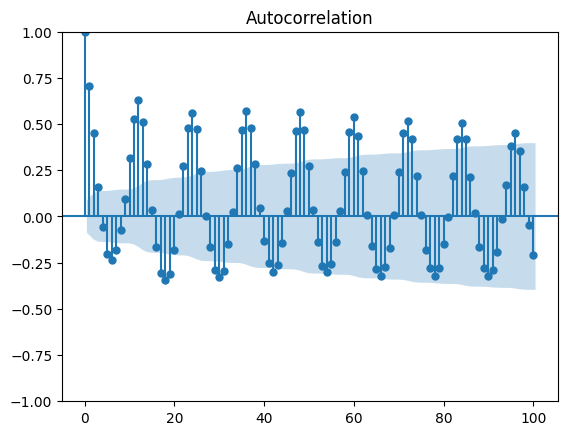

In [6]:
acf_values = plot_acf(df_monthly_mean_temp, lags=100)

##### Based on decaying ACF, we are likely dealing with an Auto Regressive process.

/Users/linustws/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



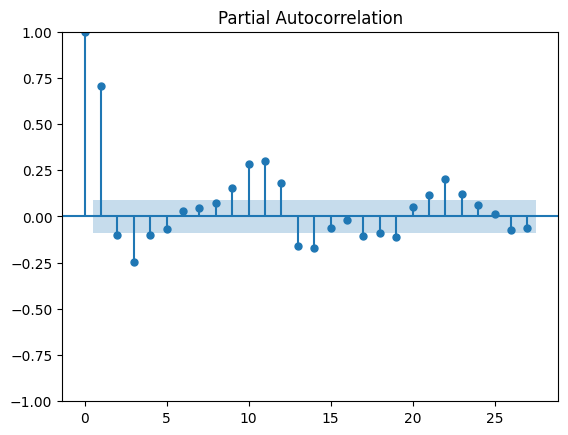

In [7]:
pacf_values = plot_pacf(df_monthly_mean_temp)

##### Based on decaying PACF, we are should start with an Auto Regressive model with lags 1, 3, 9, 10, 11, 12.

#### Augmented Dickey-Fuller Test

In [8]:
def perform_adf_test(series):
    result = adfuller(series)
    adf_statistic = result[0]
    p_value = result[1]
    print(f'ADF Statistic: {adf_statistic:.4f}')
    print(f'p-value: {p_value:.4f}')

perform_adf_test(df_monthly_mean_temp)

ADF Statistic: -4.4622
p-value: 0.0002


##### Since p-value < 0.5, time series is stationary.

### Model Validation

#### AR Model

In [9]:
# split 70:30
train_end = datetime(2011, 1, 1) 
test_end = datetime(2023, 1, 1)

train_data = df_monthly_mean_temp[:train_end]
test_data = df_monthly_mean_temp[train_end + timedelta(days=1):test_end]

# create model
model = ARIMA(train_data, order=(12, 0, 0))

# fit model
start = time()
model_fit = model.fit()
end = time()
print(f"Model Fitting Time: {end - start}")

# summary of the model
print(model_fit.summary())

Model Fitting Time: 5.105017185211182
                               SARIMAX Results                                
Dep. Variable:              mean_temp   No. Observations:                  348
Model:                ARIMA(12, 0, 0)   Log Likelihood                -236.362
Date:                Sun, 21 May 2023   AIC                            500.724
Time:                        03:13:53   BIC                            554.655
Sample:                    01-31-1982   HQIC                           522.195
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5814      0.156    176.262      0.000      27.275      27.888
ar.L1          0.5915      0.050     11.899      0.000       0.494       0.689
ar.L2         

##### We should only keep those lags with p-value < 0.5.

In [10]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

# print(residuals)

# Plot residuals
fig_resid = px.line(residuals, labels={residuals.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from AR Model')
fig_resid.update_xaxes(dtick='M12', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')
fig_resid.show()

##### Clear pattern in residual data - means that there's some dynamic data that is failed to be captured i.e. not good.

In [11]:
plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M12', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2))}")

Mean Absolute Percent Error: 0.0215
Root Mean Squared Error: 0.7288853498207665


##### AR(3) Model:
Mean Absolute Percent Error: 0.0242
Root Mean Squared Error: 0.8109909048742633

##### AR(12) Model:
Mean Absolute Percent Error: 0.0215
Root Mean Squared Error: 0.7288853498207665

##### The further we predict into the future, the worst the predictions => splitting data into train & test is not ideal for time series models.

#### Rolling Forecast Origin (Rolling Window)

##### Predict 1 month in advance each time:

Train on months 1, 2, ..., k - 3 -> predict month k - 2

Train on months 1, 2, ..., k - 3, k - 2 -> predict month k - 1

Train on months 1, 2, ..., k - 3, k - 2, k - 1 -> predict month k

...

##### Average all predictions

In [12]:
# create the model
predictions_rolling = pd.Series(dtype='float64')
start = time()
for end_date in test_data.index:
    train_data = df_monthly_mean_temp[:end_date - timedelta(days=1)]
    model = ARIMA(train_data, order=(12, 0, 0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]
end = time()
print(f"Model Fitting Time: {end - start}")
residuals_rolling = test_data - predictions_rolling

# print(residuals_rolling)

# Plot residuals
fig_resid_rolling = px.line(residuals_rolling, labels={residuals_rolling.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from AR Model (Rolling Window)')
fig_resid_rolling.update_xaxes(dtick='M12', tickangle=45)
fig_resid_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_resid_rolling.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')
fig_resid_rolling.show()

Model Fitting Time: 169.88391089439392


##### Although there is volatility in residual data, there is less pattern compared to just training on the test data in one shot (as shown above), means predictions will be closer and model is better.

In [13]:
plot_data_rolling = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions_rolling})
# print(plot_data)
fig_pred_test_rolling = px.line(plot_data_rolling, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions (Rolling Window)')
fig_pred_test_rolling.update_xaxes(dtick='M12', tickangle=45)
fig_pred_test_rolling.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test_rolling.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test_rolling.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals_rolling/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals_rolling**2))}")

Mean Absolute Percent Error: 0.0139
Root Mean Squared Error: 0.4852943576603423


##### AR(3) Model (Rolling Window):
Mean Absolute Percent Error: 0.0158
Root Mean Squared Error: 0.5362938714103711
(Model Fitting Time: 4.89312219619751)

##### AR(12) Model (Rolling Window):
Mean Absolute Percent Error: 0.0139
Root Mean Squared Error: 0.4852943576603423
(better but took way longer - Model Fitting Time: 114.35287189483643)

##### As shown, rolling window is better as it predicts 1 month in advance of the test data consecutively rather than predicting over the whole test data. Therefore, predictions are closer.

#### MA Model

Using ACF, we can know which lag/order to use for the MA model.

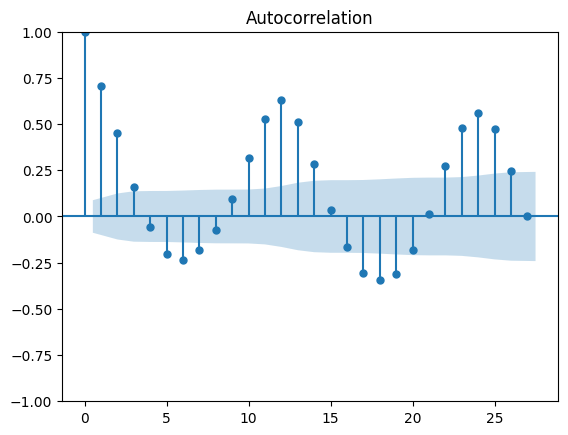

In [14]:
acf_values = plot_acf(df_monthly_mean_temp)

##### Based on decaying ACF, we should start with a Moving Average model with lags 1, 2 (for simplicity).

In [15]:
# split 70:30
train_end = datetime(2011, 1, 1)
test_end = datetime(2023, 1, 1)

train_data = df_monthly_mean_temp[:train_end]
test_data = df_monthly_mean_temp[train_end + timedelta(days=1):test_end]

# create model
model = ARIMA(train_data, order=(0, 0, 2))

# fit model
start = time()
model_fit = model.fit()
end = time()
print(f"Model Fitting Time: {end - start}")

# summary of the model
print(model_fit.summary())

Model Fitting Time: 0.0561060905456543
                               SARIMAX Results                                
Dep. Variable:              mean_temp   No. Observations:                  348
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -298.502
Date:                Sun, 21 May 2023   AIC                            605.004
Time:                        03:18:08   BIC                            620.413
Sample:                    01-31-1982   HQIC                           611.139
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5641      0.065    423.368      0.000      27.437      27.692
ma.L1          0.7289      0.052     14.098      0.000       0.628       0.830
ma.L2        

From the constants and the lag terms, we should use the predicted model:

##### ŷ(t) = 28 + 0.73ε(t-1) + 0.40ε(t-2) (ignore ε(t) as current prediction error is caught on the fly)

In this equation:

ŷ(t) represents the predicted value of the dependent variable at time t.
ε(t-1) represents the prediction error (residual) at time (t-1).
ε(t-2) represents the prediction error (residual) at time (t-2).
The coefficients 0.73 and 0.40 represent the weights assigned to the lagged prediction errors (ε).

In [16]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

# print(residuals)

# Plot residuals
fig_resid = px.line(residuals, labels={residuals.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from MA Model')
fig_resid.update_xaxes(dtick='M12', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')
fig_resid.show()

##### Similar to the AR model above (without rolling window), clear pattern in residual data - means that there's some dynamic data that is failed to be captured i.e. not good.

In [18]:
plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M12', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2))}")

Mean Absolute Percent Error: 0.0243
Root Mean Squared Error: 0.81319297543754


##### As we used MA(2) of 2 lag periods, we could only predict the first 2 months of the test data. The MA model will then predict the rest of the test data as the mean value as shown above. This is a characteristic of the MA model.

##### For simplicity, we will omit the rolling window version of the MA model.

##### AR model uses PACF whereas MA model uses ACF.

#### ARMA Model

Although the above Augmented Dickey-Fuller Test showed a low p-value implying that the series might be stationary, we cannot be too sure as it seems as if there is a slight upwards trend (possibly due to global warming) by just looking at the graph. To confirm, let's perform the first difference to check for stationarity. We can see the difference easier by comparing both graphs as shown below.

In [31]:
fig_monthly_mean_temp.show() # for easier comparison

first_diff = df_monthly_mean_temp.diff()[1:]
# print(first_diff)

# line plot for mean temperature
fig_first_diff = px.line(first_diff, labels={first_diff.index.name: 'Datetime', 'value': 'Mean Temperature (°C)'}, title='First Difference of Monthly Mean Temperature')
fig_first_diff.update_xaxes(dtick='M12', tickangle=45)
fig_first_diff.update_yaxes(dtick=0.5, tickangle=45)
fig_first_diff.update_traces(hovertemplate='Datetime: %{x}<br>Mean Temperature: %{y}°C')

# add the mean line
mean_temperature = np.mean(first_diff)
fig_first_diff.add_shape(
    type="line",
    x0=first_diff.index[0],
    y0=mean_temperature,
    x1=first_diff.index[-1],
    y1=mean_temperature,
    line=dict(color="red", dash="dot"),
)
fig_first_diff.show()

##### As the differenced series appears to be more stationary, it suggests that the original series had some form of trend or seasonality that was removed, in so doing, the data is preprocessed.

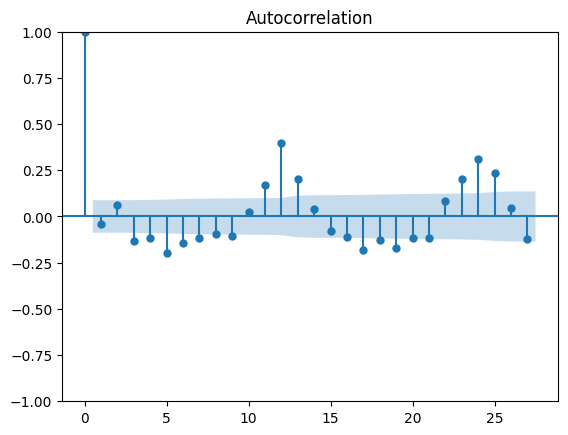

In [32]:
acf_values = plot_acf(first_diff)

##### Based on ACF, we should start with a MA(0) process.

/Users/linustws/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



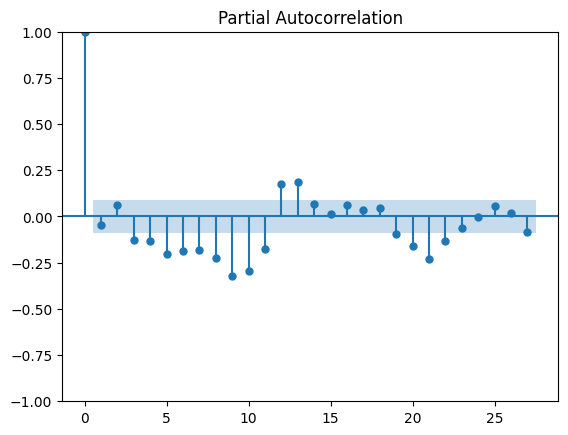

In [33]:
pacf_values = plot_pacf(first_diff)

##### Based on PACF, we should start with an AR(5) process. (9 looks the strongest here but we will omit seasonality here for simplicity)

In [42]:
# split 70:30
train_end = datetime(2011, 1, 1)
test_end = datetime(2023, 1, 1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

# create model
model = ARIMA(train_data, order=(5, 0, 0))

# fit model
start = time()
model_fit = model.fit()
end = time()
print(f"Model Fitting Time: {end - start}")

# summary of the model
print(model_fit.summary())

Model Fitting Time: 0.09499073028564453
                               SARIMAX Results                                
Dep. Variable:              mean_temp   No. Observations:                  347
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -306.179
Date:                Sun, 21 May 2023   AIC                            626.359
Time:                        04:18:21   BIC                            653.304
Sample:                    02-28-1982   HQIC                           637.087
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.022      0.076      0.939      -0.041       0.045
ar.L1         -0.0410      0.058     -0.709      0.479      -0.154       0.072
ar.L2       

In [45]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# get predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

# print(residuals)

# Plot residuals
fig_resid = px.line(residuals, labels={residuals.index.name: 'Datetime', 'value': 'Error'}, title='Residuals from ARMA Model')
fig_resid.update_xaxes(dtick='M12', tickangle=45)
fig_resid.update_yaxes(dtick=0.5, tickangle=45)
fig_resid.update_traces(name='error', hovertemplate='Datetime: %{x}<br>Error: %{y}')

# add the mean line
mean_error = np.mean(residuals)
fig_resid.add_shape(
    type="line",
    x0=residuals.index[0],
    y0=mean_error,
    x1=residuals.index[-1],
    y1=mean_error,
    line=dict(color="red", dash="dot"),
)
fig_resid.show()

In [48]:
plot_data = pd.DataFrame({'datetime': test_data.index, 'test_data': test_data.values, 'predictions': predictions})
# print(plot_data)
fig_pred_test = px.line(plot_data, x='datetime', y=['test_data', 'predictions'], labels={'datetime': 'Datetime', 'value': 'First Difference of Mean Temperature (°C)'}, title='Test Data and Predictions')
fig_pred_test.update_xaxes(dtick='M12', tickangle=45)
fig_pred_test.update_yaxes(dtick=0.5, tickangle=45)
fig_pred_test.update_traces(hovertemplate='Datetime: %{x}<br>First Difference of Mean Temperature: %{y}°C')
fig_pred_test.show()

print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data)), 4)}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2))}")

Mean Absolute Percent Error: inf
Root Mean Squared Error: 0.5948602459411223


Although predictions mirror the shape of the first difference test data at the very start, rolling window not used, thus only could predict for a small time period. Still has room for improvement.

Model Refinement: Iterate on the model development process by adjusting the model parameters, orders, or other settings to improve the accuracy. Consider experimenting with different variations of ARIMA models, such as SARIMA (Seasonal ARIMA) if your data exhibits seasonal patterns.

Web App Development: Create a web application using the chosen frontend framework, React. Design the user interface (UI) where users can input the number of days they want to forecast and select the variables they are interested in. Use forms or input fields to gather user input.

Backend Development: Implement the backend of your web app using Flask, a Python microframework. Set up the necessary routes and endpoints to handle user requests from the frontend. This includes receiving the user input, processing the request, and returning the forecasted values to the frontend.

Integration with ARIMA Model: Connect the frontend and backend by incorporating the ARIMA model into the Flask backend. When the user submits a forecast request, retrieve the selected variables and the number of days from the request. Use the trained ARIMA models to generate the forecasts for the specified variables and time horizon.

Displaying the Results: Once the forecasts are generated, return the results to the frontend and display them to the user. You can use visualizations, such as line charts or tables, to present the forecasted values in an intuitive and user-friendly manner.

Testing and Deployment: Test your web app thoroughly to ensure it functions correctly and provides accurate forecasts. Once you are satisfied with the app's performance, deploy it to a hosting platform or server so that it can be accessed by users.